# Energy community  viability analysis

This script considers the CEA outputs (demand and solar production csv files merged and named: B...._final.csv).
The outputs of this script are two dataframes:

### EC_analysis: energy performance indicators at the building level (yearly):

- Demand (kWh/year)
- PV_gen(kWh/year)

### Depending on the configuration (Energy from the grid, selfsufficiency ratio):

#### A) Building without energy community:

- E_GRID_SELFCONSUMPTION (kWh/year)
- SS_RATIO_SELFCONSUMPTION (%)

#### B) Building in energy community sharing surpluses: 

- E_GRID_EC(kWh/year)
- SS_RATIO_EC (%)

#### C) Building in energy community sharing surpluses with central battery storage:

- E_GRID_EC_CBESS(kWh/year)
- SS_RATIO_EC_CBESS (%)
             
### EC_total: energy performance indicators at the EC level (yearly) for the following configurations:

#### A) Energy community without CBESS

#### B) Energy community with CBESS
    
- Demand_kWh_year
- Grid_to_EC_kWh_year
- SS RATIO (%)
- PV_gen_kWh_year
- EC_to_GRID
- EC_Self_consumed_energy
- SC RATIO(%)
     
            
            
            


In [1]:
import pandas as pd
from glob import glob
import glob2
import os
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
import contextily as ctx
import matplotlib.pyplot as plt

In [2]:
# get current directory
currDir = os.getcwd()

## chamar os ficheiros com PV e demand

In [3]:
csvfiles_final = glob2.glob(os.path.join(currDir, 'B*[0-9]_final.csv')) # paths for the building files
buildings_shapefile = gpd.read_file(currDir + '/zone.shp')

Collect all csv files ending _final.csv

In [4]:
dataframes_final = [] #empty list
for csvfile_final in csvfiles_final:
    df_final = pd.read_csv(csvfile_final, sep =',') #opening the file
    df_final= df_final.rename(columns={'Unnamed: 0': 'Date'})# rename 1st columns
    dataframes_final.append(df_final) # append dataframe per dataframe to the list



# coluna "Date"

Create a dataframe only with date/hours to serve as basis to receive columns from other dataframes

In [5]:
dff=dataframes_final[0] # example of calling the first dataframe from the list
EC = dff[["Date"]].copy() # create a dataframe with only the first column by copying it

STEP_1: Loop on buildings dataframes to calculate Enet= Grid - PVgen. Getting the Enet columns on dataframa EC





In [6]:
for dataframe_final in dataframes_final: # loop on the several building files (dataframes) to perform the operations 
    dataframe_final['Enet1_'+dataframe_final["Name"][0]]=dataframe_final['GRID_kWh']-dataframe_final['E_PV_gen_kWh'] # give the name of the building and perform the calculation 
    EC['Enet1_'+dataframe_final["Name"][0]]=dataframe_final['Enet1_'+dataframe_final["Name"][0]] # consider the previous columns on just one dataframe

In [7]:
EC=EC.set_index("Date") #set date as index (not a column)

STEP_2 e STEP_3: EC demand and EC surplus




In [8]:
EC['EC_demand']=EC[EC>0].sum(1) # it sums all the lines and as we only have Enets it is ok.
EC['EC_surplus']=EC[EC<0].sum(1)

In [9]:
dff2=dataframes_final[0] # example of calling the first dataframe from the list
EC_dem_gen= dff2[["Date"]].copy() # create a dataframe with only the first column by copying it


In [10]:
# EC_dem_gen

In [11]:
for dataframe_final in dataframes_final: # loop on the several building files (dataframes) to perform the operations 
    dataframe_final['Edem_'+dataframe_final["Name"][0]]=dataframe_final['GRID_kWh']
    EC_dem_gen['Edem_'+dataframe_final["Name"][0]]=dataframe_final['Edem_'+dataframe_final["Name"][0]]
    dataframe_final['Egen_'+dataframe_final["Name"][0]]=dataframe_final['E_PV_gen_kWh']
    EC_dem_gen['Egen_'+dataframe_final["Name"][0]]=dataframe_final['Egen_'+dataframe_final["Name"][0]]

In [12]:
EC_dem_gen['GRID_total']= EC_dem_gen[list(EC_dem_gen.filter(regex='Edem_'))].sum(axis=1)
EC_dem_gen['PV_total']= EC_dem_gen[list(EC_dem_gen.filter(regex='Egen_'))].sum(axis=1)
#EC_total['EC_demand_total']=EC['EC_demand']
#EC_total['EC_surplus_total']=abs(EC['EC_surplus'])

In [13]:
EC_dem=EC[['EC_demand','EC_surplus']]

In [14]:
EC_hourly=pd.merge(EC_dem_gen,EC_dem,left_index=True,right_index=True,how='left')


In [15]:
# EC_hourly.head(2)

In [16]:
EC_hourly.to_csv('EC_hourly_gen_dem.csv')

STEP_4: EC_to_grid =IF(EC_surplus+EC_demand<0,-(EC_surplus+EC_demand),0)




In [17]:
#EC_to_grid:
conditions = [
(EC['EC_surplus']+EC['EC_demand']<0),
(EC['EC_surplus']+EC['EC_demand']>0)
]
choices = [
(-(EC['EC_surplus']+EC['EC_demand'])),
0]
EC["EC_to_GRID"] = np.select(conditions, choices)

STEP_5: Grid_to_EC =IF(EC_surplus+EC_demand>0,(EC_demand + EC_surplus),0)





In [18]:
#grid_to_EC:
conditions2 = [
(EC['EC_surplus']+EC['EC_demand']>0),
(EC['EC_surplus']+EC['EC_demand']<0)
]
choices2 = [
(EC['EC_demand']+EC['EC_surplus']),
0]

EC["GRID_to_EC"] = np.select(conditions2, choices2)

STEP_6: CALCULATION OF X_N(%) if (EnetN>0;XN=EnetN/Ecdemand;0)



In [19]:
EC.reset_index(inplace=True) # to do easily the merge that follows

In [20]:
# EC.head(4)

To perform operations between each building dataframe and EC columns (EC_to_GRID','GRID_to_EC') we may merge the dataframes (each building with EC) using loop

In [21]:
EC2=EC[['EC_demand','EC_to_GRID','GRID_to_EC','EC_surplus']]

In [22]:
dataframes_final2 = [] #empty list

for dataframe_final in dataframes_final: 
    dataframe_final_vf = pd.merge(dataframe_final,EC2,left_index=True,right_index=True,how='left')
    dataframes_final2.append(dataframe_final_vf)


Calculate "X_B..."

In [23]:

for dataframe_final in dataframes_final2: 
    conditions3 = [
    (dataframe_final['Enet1_'+dataframe_final["Name"][0]]>0),
    (dataframe_final['Enet1_'+dataframe_final["Name"][0]]<0)
    ]
    choices3 = [
    (dataframe_final['Enet1_'+dataframe_final["Name"][0]])/dataframe_final['EC_demand'],
    0]
    dataframe_final['X_'+dataframe_final["Name"][0]] = np.select(conditions3, choices3)


STEP_7: Calculate "Egrid_B"



In [24]:
for dataframe_final in dataframes_final2: 
    conditions4 = [
    (dataframe_final['Enet1_'+dataframe_final["Name"][0]]>0) & (dataframe_final['Enet1_'+dataframe_final["Name"][0]]+(dataframe_final['EC_surplus']*dataframe_final['X_'+dataframe_final["Name"][0]])>0)
    ,
    (dataframe_final['X_'+dataframe_final["Name"][0]]<0)
    ]
    choices4 = [
    (dataframe_final['Enet1_'+dataframe_final["Name"][0]])+dataframe_final['EC_surplus']* dataframe_final['X_'+dataframe_final["Name"][0]],
    0]
    dataframe_final['Egrid_'+dataframe_final["Name"][0]] = np.select(conditions4, choices4)

STEP_8: CBESS data




In [25]:
# calculate the daily average consumption value for sizing the battery

In [26]:
# EC

In [27]:
EC2=EC_hourly.copy()
EC2['Date'] = pd.to_datetime(EC2['Date'])

# # Definindo 'Date' como índice para facilitar o agrupamento
EC2.set_index('Date', inplace=True)


daily_sum_consumption = EC2['GRID_total'].resample('D').sum()
average_daily_consumption_year = daily_sum_consumption.mean()


In [28]:
# average_daily_consumption_year

In [29]:
CAPACITY_kWh=average_daily_consumption_year #average daily demand
SOCMAX=0.95
SOCMAX_kWh=SOCMAX*CAPACITY_kWh
SOCMIN=0.10
SOCMIN_kWh=SOCMIN*CAPACITY_kWh
EFF=0.95 
NOM_CAP=0.33
NOM_CAP_kWh=NOM_CAP*CAPACITY_kWh

In [30]:
GRID_to_EC_withoutB=EC['GRID_to_EC'].agg(lambda x : x.sum())
EC_to_GRID_withoutB=EC['EC_to_GRID'].agg(lambda x : x.sum())

daily_gridtoEC=(GRID_to_EC_withoutB/365)
daily_ECtogrid=EC_to_GRID_withoutB/365

coverage=1
batcap=daily_gridtoEC*coverage/(SOCMAX-SOCMIN)
batcap_gen=daily_ECtogrid*coverage/(SOCMAX-SOCMIN)
batcap,batcap_gen, daily_gridtoEC,daily_ECtogrid,EC_to_GRID_withoutB

(np.float64(536.9705656728445),
 np.float64(1082.85911361805),
 np.float64(456.42498082191776),
 np.float64(920.4302465753426),
 np.float64(335957.04000000004))

STEP 9 // STEP 10 // STEP 11 //STEP 12 // STEP 13




In [31]:
EC['EFF']=0.95
EC['NOM_CAP_kWh']=NOM_CAP_kWh
EC.loc[-1,'SOC']=SOCMAX_kWh

for i in range(0,8760):
    # STEP 9
    EC.loc[i,'ESOC_D']=max(EC.loc[i-1,'SOC']-SOCMIN_kWh,0) 
    
    # STEP 10
    EC.loc[i,'ESOC_C']=max(SOCMAX_kWh-EC.loc[i-1,'SOC'],0) 
    
    # STEP 11
    conditions5=[
        EC.loc[i,'ESOC_D']>EC.loc[i,'GRID_to_EC'],
        EC.loc[i,'ESOC_D']<EC.loc[i,'GRID_to_EC']
        ]

    choices5=[
        min(EC.loc[i,'GRID_to_EC']/EFF,NOM_CAP_kWh),
        min(EC.loc[i,'ESOC_D']/EFF,NOM_CAP_kWh)
        ]
    EC.loc[i,'DISC']=np.select(conditions5,choices5)
    
    # STEP 12
    conditions6=[
        EC.loc[i,'ESOC_C']>EC.loc[i,'EC_to_GRID'],
        EC.loc[i,'ESOC_C']<EC.loc[i,'EC_to_GRID']
        ]

    choices6=[
        min(EC.loc[i,'EC_to_GRID']*EFF,NOM_CAP_kWh),
        min(EC.loc[i,'ESOC_C']*EFF,NOM_CAP_kWh)
        ]
    EC.loc[i,'CHAR']=np.select(conditions6,choices6)    
    
    #STEP 13:
    if(EC.loc[i,'DISC']>0):
        EC.loc[i,'SOC']=max(EC.loc[i-1,'SOC']-EC.loc[i,'DISC'],SOCMIN_kWh)
    else:
        EC.loc[i,'SOC']=min(EC.loc[i-1,'SOC']+EC.loc[i,'CHAR'],SOCMAX_kWh)

#STEP 14 EC to GRID_B (t) Calculation of the energy flow TO the GRID with BESS '=MAX(EC_to_GRID(t)-CHAR(t);0)

In [ ]:
for i in range(0,8760):
    EC.loc[i,'EC_to_GRID_B']=max(EC.loc[i,'EC_to_GRID']-EC.loc[i,'CHAR'],0)

#STEP 15 GRID to EC_B (t)	Calculation of the energy flow FROM the GRID with BESS	=MAX(GRID_to_EC(t)-DISC(t);0)


In [ ]:
for i in range(0,8760):
    EC.loc[i,'GRID_to_EC_B']=max(EC.loc[i,'GRID_to_EC']-EC.loc[i,'DISC'],0)
    

In [ ]:
EC.to_csv('EC_bess.csv')

STEP 16 Egrid_N_BESS Calculation of the Egrid for each building after BESS '=X_N*GRID_to_EC

In [ ]:
dataframes_final3 = [] #empty list
for dataframe_final in dataframes_final2: 
    dataframe_final = pd.merge(dataframe_final,EC[['GRID_to_EC_B','EC_to_GRID_B']],left_index=True,right_index=True,how='left')
    dataframes_final3.append(dataframe_final)
    

In [ ]:
for dataframe_final in dataframes_final3: 
    dataframe_final['EgridBESS_'+dataframe_final["Name"][0]] = dataframe_final['X_'+dataframe_final["Name"][0]]*dataframe_final['GRID_to_EC_B']
    

In [ ]:
#EC TARIFF


In [ ]:
tariff = pd.read_csv('tariffs_imb.csv', sep =',')

In [ ]:
tariff.reset_index(inplace=True) # to do easily the merge that dollows

In [ ]:
dataframes_final4=[]
for dataframe_final in dataframes_final3: 
    dataframe_final = pd.concat([dataframe_final,tariff],axis=1) # add the day type and months for the savings calculation
    dataframes_final4.append(dataframe_final)

In [ ]:
#for dataframe_final in dataframes_final4:
#    dataframe_final['Cost_SC'[0]] = dataframe_final['Enet1_'+dataframe_final["Name"][0]]*dataframe_final['Tariff_self_cons']

In [ ]:
#for dataframe_final in dataframes_final4:
 #   dataframe_final['Cost_EC'[0]]=dataframe_final['Egrid_'+dataframe_final["Name"][0]]*dataframe_final['Tariff_EC']

In [ ]:
dataframes_final4[1].to_csv('EC_d1bfinal.csv')

In [ ]:
for dataframe_final in dataframes_final4:
    dataframe_final['Cost_base']=dataframe_final['GRID_kWh']*dataframe_final['Tariff_base']
    dataframe_final['Cost_SC'] = dataframe_final['Enet1_'+dataframe_final["Name"][0]]*dataframe_final['Tariff_self_cons']
    dataframe_final['Cost_EC']=dataframe_final['Egrid_'+dataframe_final["Name"][0]]*dataframe_final['Tariff_EC']
    dataframe_final['Cost_EC_BESS']=dataframe_final['EgridBESS_'+dataframe_final["Name"][0]]*dataframe_final['Tariff_EC_BESS']
    dataframe_final['Income'] =dataframe_final['Enet1_'+dataframe_final["Name"][0]]*dataframe_final['Tariff_surp']
    dataframe_final['Income_EC'] =dataframe_final['EC_to_GRID']*dataframe_final['Tariff_surp']
    dataframe_final['Income_EC_B'] =dataframe_final['EC_to_GRID_B']*dataframe_final['Tariff_surp']

In [ ]:
B_savings=[]
for dataframe_final in dataframes_final4: 
    B_savings.append(dataframe_final["Name"][0])
    
B_savings = pd.DataFrame({"Building":B_savings})   

In [ ]:
B_savings.head(2)

,Building
0,B1022
1,B1031


In [ ]:
for dataframe_final in dataframes_final4:
    locals()["Total_cost_base"+ str(dataframe_final["Name"][0])]= dataframe_final['Cost_base'].agg(lambda x : x.sum())
    locals()["Total_cost_SC"+ str(dataframe_final["Name"][0])]= dataframe_final['Cost_SC'].agg(lambda x : x[x > 0].sum())
    locals()["Total_cost_EC"+ str(dataframe_final["Name"][0])]= dataframe_final['Cost_EC'].agg(lambda x : x.sum())
    locals()["Total_cost_EC_BESS"+ str(dataframe_final["Name"][0])]= dataframe_final['Cost_EC_BESS'].agg(lambda x : x.sum())
    locals()["Income_PV"+ str(dataframe_final["Name"][0])]=-1*( dataframe_final['Income'].agg(lambda x : x[x < 0].sum()))
    locals()["Surpluses"+ str(dataframe_final["Name"][0])]=abs(dataframe_final['Enet1_'+dataframe_final["Name"][0]].agg(lambda x : x[x < 0].sum()))
    locals()["SurpluesEC"+ str(dataframe_final["Name"][0])]= dataframe_final['EC_to_GRID'].agg(lambda x : x.sum())
    locals()["SurpluesEC_B"+ str(dataframe_final["Name"][0])]= dataframe_final['EC_to_GRID_B'].agg(lambda x : x.sum())
    locals()["Income_EC_total"+ str(dataframe_final["Name"][0])]= dataframe_final['Income_EC'].agg(lambda x : x.sum())
    locals()["Income_EC_B_total"+ str(dataframe_final["Name"][0])]= dataframe_final['Income_EC_B'].agg(lambda x : x.sum())

In [ ]:
for i in range(len(B_savings)):
    B_savings.loc[i,'Ecost_base (€)']=locals()["Total_cost_base"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'Ecost_SC (€)']=locals()["Total_cost_SC"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'Ecost_EC (€)']=locals()["Total_cost_EC"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'Ecost_EC_BESS (€)']=locals()["Total_cost_EC_BESS"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'Savings_SC (€)']=locals()["Total_cost_base"+B_savings.loc[i,'Building']]-locals()["Total_cost_SC"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'Savings_SC (%)']=(locals()["Total_cost_base"+B_savings.loc[i,'Building']]-locals()["Total_cost_SC"+B_savings.loc[i,'Building']])/(locals()["Total_cost_base"+B_savings.loc[i,'Building']])
    B_savings.loc[i,'Savings_EC (€)']=locals()["Total_cost_base"+B_savings.loc[i,'Building']]-locals()["Total_cost_EC"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'Savings_EC (%)']=(locals()["Total_cost_base"+B_savings.loc[i,'Building']]-locals()["Total_cost_EC"+B_savings.loc[i,'Building']])/(locals()["Total_cost_base"+B_savings.loc[i,'Building']])
    B_savings.loc[i,'Savings_EC_BESS (€)']=locals()["Total_cost_base"+B_savings.loc[i,'Building']]-locals()["Total_cost_EC_BESS"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'Savings_EC_BESS (%)']=(locals()["Total_cost_base"+B_savings.loc[i,'Building']]-locals()["Total_cost_EC_BESS"+B_savings.loc[i,'Building']])/(locals()["Total_cost_base"+B_savings.loc[i,'Building']])
    B_savings.loc[i,'Income_PV_SC(€)']=locals()["Income_PV"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'Income_PV_EC(€)']=locals()["Surpluses"+B_savings.loc[i,'Building']]/locals()["SurpluesEC"+B_savings.loc[i,'Building']]*locals()["Income_EC_total"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'Income_PV_EC_B(€)']=locals()["Surpluses"+B_savings.loc[i,'Building']]/locals()["SurpluesEC_B"+B_savings.loc[i,'Building']]*locals()["Income_EC_B_total"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'incomeEC_total']=locals()["Income_EC_total"+B_savings.loc[i,'Building']]
    B_savings.loc[i,'incomeEC_b_total']=locals()["Income_EC_B_total"+B_savings.loc[i,'Building']]

In [ ]:
B_savings.head(2)

,Building,Ecost_base (€),Ecost_SC (€),Ecost_EC (€),Ecost_EC_BESS (€),Savings_SC (€),Savings_SC (%),Savings_EC (€),Savings_EC (%),Savings_EC_BESS (€),Savings_EC_BESS (%),Income_PV_SC(€),Income_PV_EC(€),Income_PV_EC_B(€),incomeEC_total,incomeEC_b_total
0,B1022,2974.625115,1547.009007,1484.449948,809.333290,1427.616107,0.479931,1490.175167,0.500962,2165.291824,0.727921,1561.790430,1582.678090,1565.997347,32576.829626,25028.23918
1,B1031,1892.020279,1341.847883,1327.194524,689.904345,550.172397,0.290786,564.825755,0.298530,1202.115935,0.635361,2101.221599,2080.185719,2058.261460,32576.829626,25028.23918


In [ ]:
B_savings.to_csv('EC_building_savings.csv')

In [ ]:
#don't consider the columns created with random letters, was only confirming step by step the calculations.
#here there's an error in the last columns : Income EC_total and income EC_B_total
#the total should be 2803 and 2394 
#nevertheless,FOR OTHER BUILDINGS the total is 2779 and 2370. 
#the total income should be the same for all the cases bc EC_to_Grid and EC_to_Grid_B should be the same in all folders. 
#i can't find where is the error, the operation is exactly the same
#Ec_to_grid is the same in all folders, and tariff_surplus also, dont understand why at the end the sum in not the same. makes no sense.

In [ ]:
E_total_cost_base=B_savings['Ecost_base (€)'].agg(lambda x : x.sum())
E_total_cost_SC=B_savings['Ecost_SC (€)'].agg(lambda x : x.sum())
E_total_cost_EC=B_savings['Ecost_EC (€)'].agg(lambda x : x.sum())
E_total_cost_EC_B=B_savings['Ecost_EC_BESS (€)'].agg(lambda x : x.sum())
E_total_income_EC=B_savings['Income_PV_EC(€)'].agg(lambda x : x.sum())
E_total_income_EC_B=B_savings['Income_PV_EC_B(€)'].agg(lambda x : x.sum())

In [ ]:
EC_total_savings = pd.DataFrame()

In [ ]:
EC_total_savings.loc[0,'Energy_cost_base (€)']=E_total_cost_base
EC_total_savings.loc[0,'Energy_cost_EC (€)']=E_total_cost_EC
EC_total_savings.loc[0,'Savings (€)']=E_total_cost_base - E_total_cost_EC
EC_total_savings.loc[0,'Savings (%)']=(E_total_cost_base - E_total_cost_EC)/E_total_cost_base
EC_total_savings.loc[0,'Income_PV_total(€)']=E_total_income_EC

In [ ]:
EC_total_savings.loc[1,'Energy_cost_base (€)']=E_total_cost_base
EC_total_savings.loc[1,'Energy_cost_EC (€)']=E_total_cost_EC_B
EC_total_savings.loc[1,'Savings (€)']=E_total_cost_base - E_total_cost_EC_B
EC_total_savings.loc[1,'Savings (%)']=(E_total_cost_base - E_total_cost_EC_B)/E_total_cost_base
EC_total_savings.loc[1,'Income_PV_total(€)']=E_total_income_EC_B

In [ ]:
EC_total_savings.rename(index={0: 'Without BESS',1:'With BESS'},inplace=True)

In [ ]:
EC_total_savings

,Energy_cost_base (€),Energy_cost_EC (€),Savings (€),Savings (%),Income_PV_total(€)
Without BESS,49489.080152,25217.177463,24271.902689,0.490450,32863.504471
With BESS,49489.080152,13727.100347,35761.979805,0.722624,32517.137337


In [ ]:
EC_total_savings.to_csv('EC_total_savings.csv')

# EC_analysis
analysis at the building level

In [ ]:
EC_analysis=[]
for dataframe_final in dataframes_final3: 
    EC_analysis.append(dataframe_final["Name"][0])
    
EC_analysis = pd.DataFrame({"Building":EC_analysis})                                             

In [ ]:
for dataframe_final in dataframes_final3:
    locals()["EC_"+ str(dataframe_final["Name"][0])]= dataframe_final['Enet1_'+dataframe_final["Name"][0]].agg(lambda x : x[x > 0].sum())
    locals()["Egrid_"+ str(dataframe_final["Name"][0])]= dataframe_final['Egrid_'+dataframe_final["Name"][0]].agg(lambda x : x.sum())
    locals()["ECgridBESS_"+ str(dataframe_final["Name"][0])]= dataframe_final['EgridBESS_'+dataframe_final["Name"][0]].agg(lambda x : x.sum())
    locals()["GRID_kWh_"+ str(dataframe_final["Name"][0])]= dataframe_final['GRID_kWh'].agg(lambda x : x.sum())
    
    locals()["PV_gen(kWh/year)_"+ str(dataframe_final["Name"][0])]= dataframe_final['E_PV_gen_kWh'].agg(lambda x : x.sum())
    locals()["SURPLUS_"+ str(dataframe_final["Name"][0])]= abs(dataframe_final['Enet1_'+dataframe_final["Name"][0]].agg(lambda x : x[x < 0].sum()))
    locals()["Self_consumed_energy_"+ str(dataframe_final["Name"][0])]=  locals()["PV_gen(kWh/year)_"+ str(dataframe_final["Name"][0])]-locals()["SURPLUS_"+ str(dataframe_final["Name"][0])]
    #demand
    locals()["Demand_"+ str(dataframe_final["Name"][0])]= dataframe_final['GRID_kWh'].agg(lambda x : x.sum())


In [ ]:
for i in range(len(EC_analysis)):
    EC_analysis.loc[i,'Demand (kWh/year)']=locals()["Demand_"+EC_analysis.loc[i,'Building']]
    
    EC_analysis.loc[i,'PV_gen(kWh/year)']=locals()["PV_gen(kWh/year)_"+EC_analysis.loc[i,'Building']]
    
    EC_analysis.loc[i,'SELFCONS (kWh/year)']=locals()["EC_"+EC_analysis.loc[i,'Building']]
    EC_analysis.loc[i,'SELFCONS (SS RATIO)']=1-EC_analysis.loc[i,'SELFCONS (kWh/year)']/locals()["GRID_kWh_"+EC_analysis.loc[i,'Building']]
    
    EC_analysis.loc[i,'EC_SHARING (kWh/year)']=locals()["Egrid_"+EC_analysis.loc[i,'Building']]
    EC_analysis.loc[i,'EC_SHARING (SS RATIO)']= 1-EC_analysis.loc[i,'EC_SHARING (kWh/year)']/locals()["GRID_kWh_"+EC_analysis.loc[i,'Building']]
    
    EC_analysis.loc[i,'EC_BESS (kWh/year)']=locals()["ECgridBESS_"+EC_analysis.loc[i,'Building']]
    EC_analysis.loc[i,'EC_BESS (SS RATIO)']=1- EC_analysis.loc[i,'EC_BESS (kWh/year)']/locals()["GRID_kWh_"+EC_analysis.loc[i,'Building']]
    

    EC_analysis.loc[i,'Self_consumed_energy (kWh/year)']=locals()["Self_consumed_energy_"+EC_analysis.loc[i,'Building']]
    
    


In [ ]:
# EC_analysis

In [ ]:
EC_analysis.to_csv('EC_analysis_buildings.csv')

# EC_total
analysis at the EC level

EC without Bat

In [ ]:
Demand=EC_analysis['Demand (kWh/year)'].agg(lambda x : x.sum())

In [ ]:
PV_gen_kWh_year= EC_analysis['PV_gen(kWh/year)'].agg(lambda x : x.sum())

In [ ]:
EC_to_GRID_withoutB=EC['EC_to_GRID'].agg(lambda x : x.sum())

In [ ]:
EC_Self_consumed_energy_withoutB=PV_gen_kWh_year-EC_to_GRID_withoutB

In [ ]:
GRID_to_EC_withoutB=EC['GRID_to_EC'].agg(lambda x : x.sum())

In [ ]:
EC_total = pd.DataFrame()

In [ ]:
EC_total.loc[0,'Demand_(kWh_year)']=Demand
EC_total.loc[0,'PV_gen_(kWh_year)']=PV_gen_kWh_year
EC_total.loc[0,'EC_to_GRID_(kWh_year)']=EC_to_GRID_withoutB
EC_total.loc[0,'EC_Self_consumed_energy_(kWh_year)']=EC_Self_consumed_energy_withoutB
EC_total.loc[0,'SC RATIO(%)']=EC_Self_consumed_energy_withoutB/PV_gen_kWh_year
EC_total.loc[0,'GRID_to_EC_(kWh_year)']=GRID_to_EC_withoutB
EC_total.loc[0,'SS RATIO(%)']=1-(GRID_to_EC_withoutB/Demand)

EC with Bat

In [ ]:
# Demand is the same

In [ ]:
# PV_gen_kWh_year is the same

In [ ]:
EC_to_GRID_withB=EC['EC_to_GRID_B'].agg(lambda x : x.sum())

In [ ]:
EC_Self_consumed_energy_withB=PV_gen_kWh_year-EC_to_GRID_withB

In [ ]:
GRID_to_EC_withB=EC['GRID_to_EC_B'].agg(lambda x : x.sum())

In [ ]:
SOC_sum=EC['SOC'].agg(lambda x : x.sum())

In [ ]:
EC_total.loc[1,'Demand_(kWh_year)']=Demand
EC_total.loc[1,'PV_gen_(kWh_year)']=PV_gen_kWh_year
EC_total.loc[1,'EC_to_GRID_(kWh_year)']=EC_to_GRID_withB
EC_total.loc[1,'EC_Self_consumed_energy_(kWh_year)']=EC_Self_consumed_energy_withB
EC_total.loc[1,'SC RATIO(%)']=EC_Self_consumed_energy_withB/PV_gen_kWh_year
EC_total.loc[1,'GRID_to_EC_(kWh_year)']=GRID_to_EC_withB
EC_total.loc[1,'SS RATIO(%)']=1-(GRID_to_EC_withB/Demand)
EC_total.loc[1,'AVERAGE SOC(%)']=(SOC_sum-SOCMAX_kWh)/8760/CAPACITY_kWh

In [ ]:
EC_total.rename(index={0: 'Without BESS',1:'With BESS'},inplace=True)

In [ ]:
# EC_total

In [ ]:
EC_total.to_csv('EC_analysis_total.csv')

## Gráfico SS e SC ratio

              Demand_(kWh_year)  PV_gen_(kWh_year)  EC_to_GRID_(kWh_year)  \
Without BESS         312628.428          481990.35          335957.040000   
With BESS            312628.428          481990.35          260859.582287   

              EC_Self_consumed_energy_(kWh_year)  SC RATIO(%)  \
Without BESS                       146033.310000     0.302980   
With BESS                          221130.767713     0.458787   

              GRID_to_EC_(kWh_year)  SS RATIO(%)  AVERAGE SOC(%)  
Without BESS          166595.118000     0.467115             NaN  
With BESS              94088.333381     0.699041        0.578669  


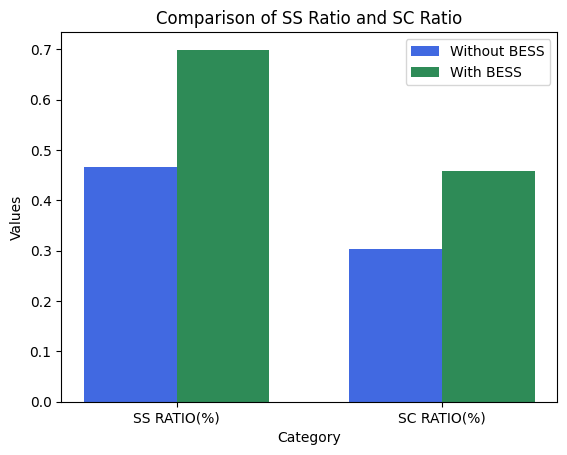

In [ ]:
# Preparando os dados para o gráfico de barras
categories = ['SS RATIO(%)', 'SC RATIO(%)']
print(EC_total)
values_without_bess = EC_total.loc['Without BESS', categories].values.flatten()
values_with_bess = EC_total.loc['With BESS', categories].values.flatten()

# Criando o gráfico de barras
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(categories))

bar1 = ax.bar(index, values_without_bess, bar_width, label='Without BESS', color='royalblue')
bar2 = ax.bar([p + bar_width for p in index], values_with_bess, bar_width, label='With BESS', color='seagreen')

# Adicionando detalhes ao gráfico
ax.set_xlabel('Category')
ax.set_ylabel('Values')
ax.set_title('Comparison of SS Ratio and SC Ratio')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(categories)
ax.legend()

plt.show()

## Gráfico Energy Cost

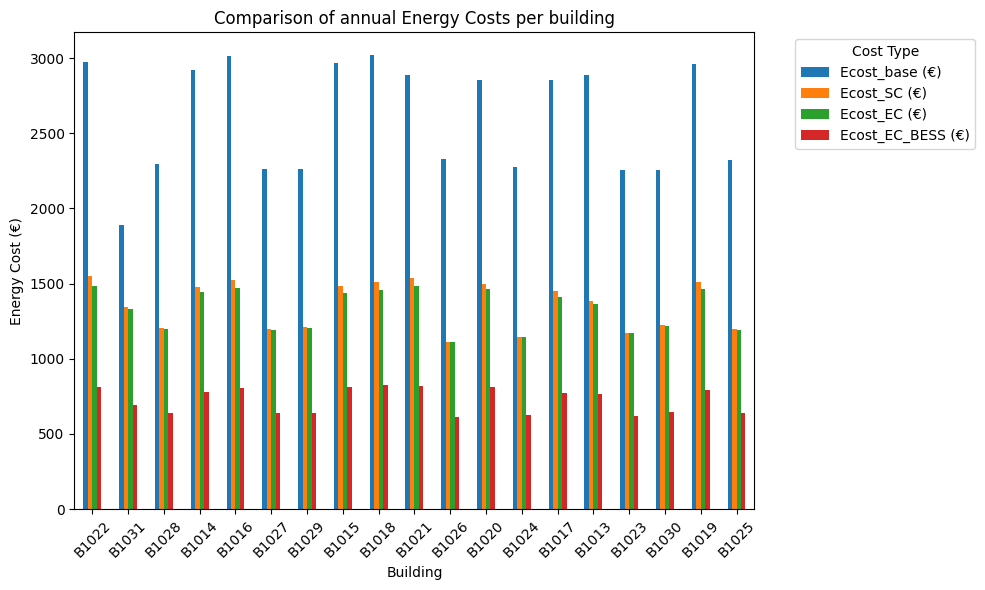

In [ ]:

# Selecionando os dados relevantes
cost_columns = ['Ecost_base (€)', 'Ecost_SC (€)', 'Ecost_EC (€)', 'Ecost_EC_BESS (€)']
cost_data = B_savings[cost_columns]

# Criando o gráfico
cost_data.plot(kind='bar', figsize=(10, 6))

plt.title('Comparison of annual Energy Costs per building')
plt.xlabel('Building')
plt.ylabel('Energy Cost (€)')
plt.xticks(ticks=range(len(B_savings)), labels=B_savings['Building'], rotation=45)
plt.legend(title='Cost Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Mapa

In [ ]:
# Garantir que o identificador do edifício seja do mesmo tipo nos dois DataFrames
buildings_shapefile['Name'] = buildings_shapefile['Name'].astype(str)
B_savings['Building'] = B_savings['Building'].astype(str)

# Integrar os dados de economia de energia com o shapefile
gdf_merged = buildings_shapefile.merge(B_savings,left_on='Name', right_on='Building',how='left')

# Escolha do dado a ser mapeado, por exemplo, 'Ecost_base (€)'
variable = 'Ecost_base (€)'

# # Criar o mapa
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# gdf_merged.plot(column=variable, ax=ax, legend=True,
#                 legend_kwds={'label': "Custos anuais de Energia por Edifício (€)",
#                              'orientation': "horizontal"})
# plt.show()

In [ ]:
buildings_shapefile.head()

,Name,REFERENCE,category,descriptio,floors_ag,floors_bg,height_ag,height_bg,geometry
0,B1013,CEA - assumption,yes,None,4,1,12,3,"POLYGON ((483306.294 14291318.010, 483290.201 ..."
1,B1014,CEA - assumption,yes,None,4,1,12,3,"POLYGON ((483322.386 14291323.902, 483306.294 ..."
2,B1015,CEA - assumption,yes,None,4,1,12,3,"POLYGON ((483292.485 14291344.726, 483276.393 ..."
3,B1016,CEA - assumption,yes,None,4,1,12,3,"POLYGON ((483308.577 14291350.607, 483292.485 ..."
4,B1017,CEA - assumption,yes,None,4,1,12,3,"POLYGON ((483293.892 14291377.614, 483277.800 ..."


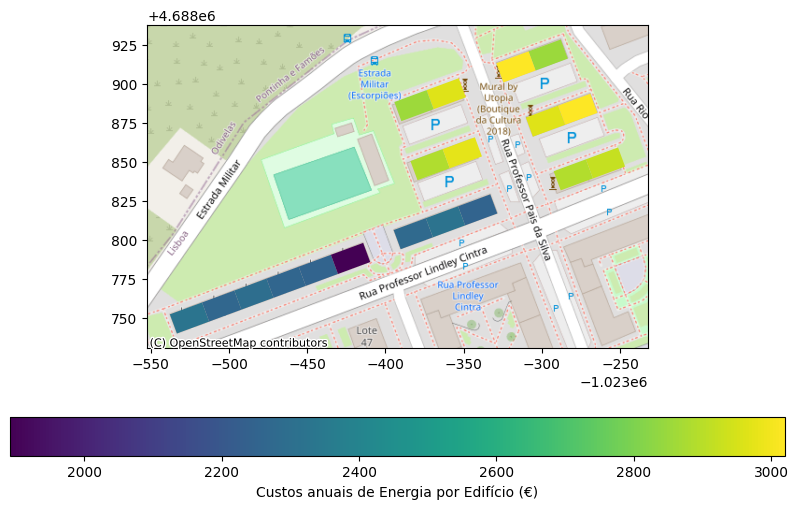

In [ ]:
# Criar o mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

gdf_merged = gdf_merged.to_crs(epsg=3857)

gdf_merged.plot(column=variable, ax=ax, legend=True,
                legend_kwds={'label': "Custos anuais de Energia por Edifício (€)",
                             'orientation': "horizontal"})

# Adicionar o mapa base do OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

In [ ]:
print(gdf_merged.crs)